https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/2_RNN.ipynb

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np # type: ignore
import pandas as pd
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
data_dir = 'C:/Users/diana/Desktop/proiect test/energy_client/'
energy = load_data(data_dir)[['load']]
energy.head()

,load
2023-05-15 00:15:00,0.13
2023-05-15 00:30:00,0.13
2023-05-15 00:45:00,0.13
2023-05-15 01:00:00,0.11
2023-05-15 01:15:00,0.10


In [3]:
valid_start_dt = '2023-05-19 05:00:00'
test_start_dt = '2023-05-20 14:30:00'

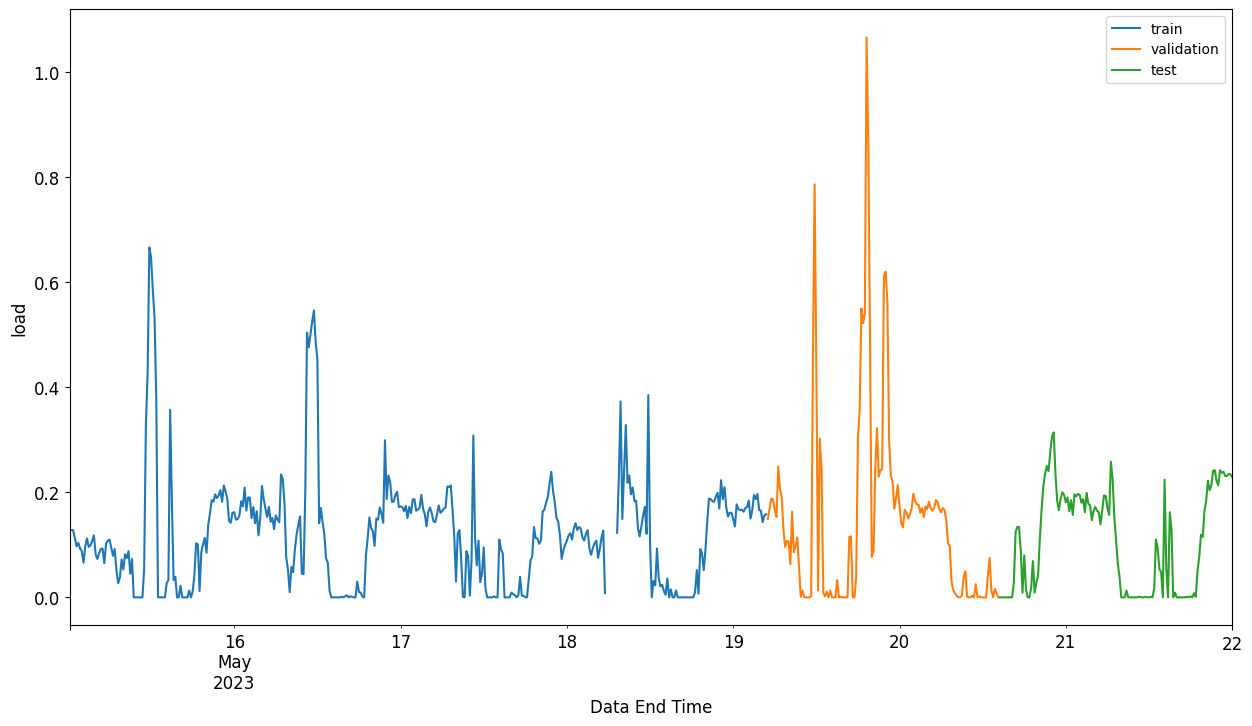

In [4]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('Data End Time', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [5]:
T = 6
HORIZON = 1

In [6]:
# 1. Get the train data from the correct data range
train = energy.copy()[energy.index < valid_start_dt][['load']]

# 2. Scale data to be in range (0, 1). 
#   This transformation should be calibrated on the training set only. 
#   This is to prevent information from the validation or test sets 
#   leaking into the training data.
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)

# 3. Shift the dataframe to create the input samples.
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
y_col = 'y_t+1'
X_cols = ['load_t-5',
             'load_t-4',
             'load_t-3',
             'load_t-2',
             'load_t-1',
             'load_t']
train_shifted.columns = ['load_original']+[y_col]+X_cols

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2023-05-15 05:15:00,0.10,0.14,0.19,0.15,0.10,0.15,0.11,0.10
2023-05-15 05:30:00,0.15,0.12,0.19,0.16,0.15,0.16,0.13,0.15
2023-05-15 05:45:00,0.16,0.14,0.19,0.14,0.17,0.18,0.14,0.16
2023-05-15 06:00:00,0.17,0.08,0.17,0.13,0.14,0.12,0.14,0.17
2023-05-15 06:15:00,0.14,0.04,0.15,0.10,0.15,0.11,0.10,0.14


In [7]:
# 5.Transform this Pandas dataframe into a numpy array
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [8]:
# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [9]:
y_train.shape

(349,)

In [10]:
y_train[:3]

array([0.14, 0.12, 0.14])

In [11]:
X_train.shape

(349, 6, 1)

In [12]:
X_train[:3]

array([[[0.19],
        [0.15],
        [0.1 ],
        [0.15],
        [0.11],
        [0.1 ]],

       [[0.19],
        [0.16],
        [0.15],
        [0.16],
        [0.13],
        [0.15]],

       [[0.19],
        [0.14],
        [0.17],
        [0.18],
        [0.14],
        [0.16]]])

In [13]:
train_shifted.head(3)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2023-05-15 05:15:00,0.10,0.14,0.19,0.15,0.10,0.15,0.11,0.10
2023-05-15 05:30:00,0.15,0.12,0.19,0.16,0.15,0.16,0.13,0.15
2023-05-15 05:45:00,0.16,0.14,0.19,0.14,0.17,0.18,0.14,0.16


In [14]:
# 1. Get the validation data from the correct data range
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]

# 2. Scale the series using the transformer fitted on the training set:
valid['load'] = scaler.transform(valid)

# 3. Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
    
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2023-05-19 05:00:00,0.22,0.25,0.22,0.25,0.26,0.29,0.25,0.22
2023-05-19 05:15:00,0.25,0.23,0.20,0.25,0.28,0.28,0.21,0.25
2023-05-19 05:30:00,0.28,0.37,0.27,0.24,0.23,0.30,0.23,0.28


In [15]:
# 5.Transform this Pandas dataframe into a numpy array
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [16]:
y_valid.shape

(130,)

In [17]:
y_valid[:3]

array([0.25, 0.23, 0.37])

In [18]:
X_valid.shape

(130, 6, 1)

In [19]:
X_valid[:3]

array([[[0.22],
        [0.25],
        [0.26],
        [0.29],
        [0.25],
        [0.22]],

       [[0.2 ],
        [0.25],
        [0.28],
        [0.28],
        [0.21],
        [0.25]],

       [[0.27],
        [0.24],
        [0.23],
        [0.3 ],
        [0.23],
        [0.28]]])

In [20]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [21]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples

In [22]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [23]:
model.compile(optimizer='RMSprop', loss='mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5)                 120       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [25]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [26]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/10
11/11 [==============================] - 3s 60ms/step - loss: 0.0388 - val_loss: 0.0825
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0283 - val_loss: 0.0752
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0262 - val_loss: 0.0731
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0258 - val_loss: 0.0730
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0256 - val_loss: 0.0721
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0255 - val_loss: 0.0713
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0253 - val_loss: 0.0715
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0251 - val_loss: 0.0712
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0249 - val_loss: 0.0710
Epoch 10/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0248 - val_loss: 0.0705


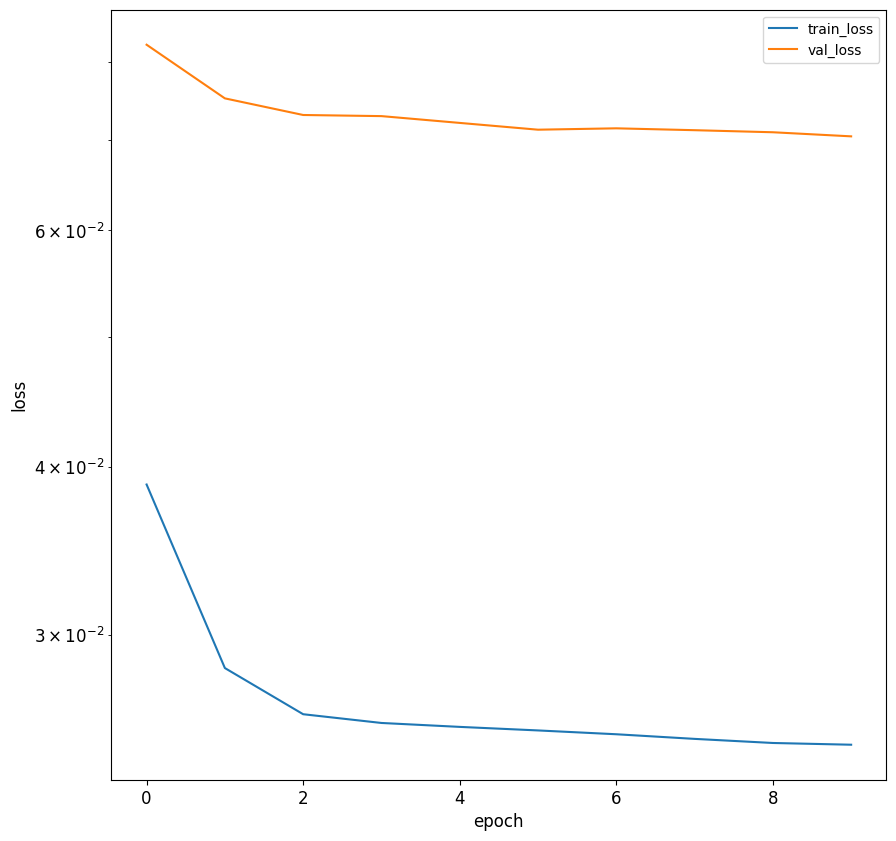

In [27]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [28]:
# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]

# 2. Scale the data
test['load'] = scaler.transform(test)

# 3. Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')

# 4.Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)

In [29]:
y_test.shape

(111,)

In [30]:
X_test.shape

(111, 6, 1)

In [31]:
predictions = model.predict(X_test)
predictions

4/4 [==============================] - 1s 0s/step


array([[0.13],
       [0.14],
       [0.15],
       [0.17],
       [0.17],
       [0.18],
       [0.19],
       [0.21],
       [0.21],
       [0.22],
       [0.23],
       [0.24],
       [0.22],
       [0.22],
       [0.22],
       [0.23],
       [0.22],
       [0.22],
       [0.21],
       [0.22],
       [0.21],
       [0.21],
       [0.21],
       [0.22],
       [0.21],
       [0.22],
       [0.21],
       [0.21],
       [0.21],
       [0.21],
       [0.21],
       [0.21],
       [0.21],
       [0.2 ],
       [0.21],
       [0.21],
       [0.21],
       [0.2 ],
       [0.2 ],
       [0.2 ],
       [0.21],
       [0.21],
       [0.2 ],
       [0.2 ],
       [0.23],
       [0.22],
       [0.2 ],
       [0.19],
       [0.19],
       [0.18],
       [0.16],
       [0.16],
       [0.16],
       [0.15],
       [0.14],
       [0.14],
       [0.14],
       [0.14],
       [0.13],
       [0.13],
       [0.13],
       [0.13],
       [0.13],
       [0.13],
       [0.13],
       [0.13],
       [0.

In [32]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2023-05-20 19:30:00,t+1,0.09,0.17
1,2023-05-20 19:45:00,t+1,0.09,0.21
2,2023-05-20 20:00:00,t+1,0.10,0.24
3,2023-05-20 20:15:00,t+1,0.11,0.25
4,2023-05-20 20:30:00,t+1,0.11,0.24


In [33]:
# %load -s mape common/utils.py
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [34]:
mape(eval_df['prediction'], eval_df['actual'])

inf

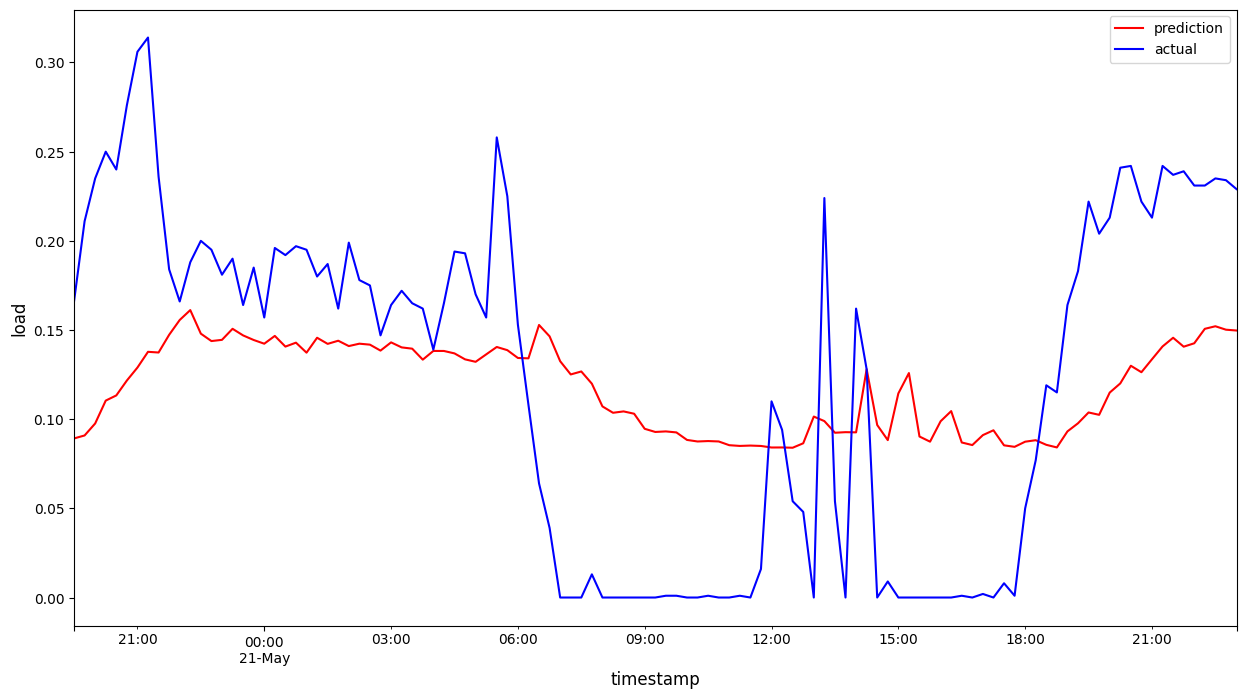

In [35]:
eval_df[eval_df.timestamp<'2023-05-23'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()